# Instalação de dependências

In [18]:
!pip install pydicom

In [19]:
from IPython.display import display, HTML

import os

from matplotlib import pyplot, ticker

from PIL import Image

import re

from zipfile import ZipFile

import numpy

import pandas
from pandas import DataFrame

import pydicom

from sklearn.metrics import classification_report, confusion_matrix

from sklearn.model_selection import StratifiedKFold

from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras import Sequential

# base models
from tensorflow.keras.applications import ResNet50, InceptionV3, ResNet101, InceptionResNetV2, ResNet152

# callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

# layers
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

from tensorflow.keras.losses import CategoricalCrossentropy

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tqdm.notebook import tqdm

In [20]:
pandas.set_option('display.width', None)

In [21]:
# DRIVE_PATH = '/content/gdrive'
DICOM_PATH = 'siim-covid19-detection.zip'
CSV_FILENAME = 'train_study_level.csv'
DATA_PATH = './siim-covid19-detection-images/'
LABEL_COL_NAME = 'cat'
FILENAME_COL_NAME = 'filename'
DATA_OUTPUT_FORMAT = 'png'
CREATE_DATASET = False
TARGET_SIZE = (224, 224)
K_FOLDS = 5
EPOCHS = 30
BATCH_SIZE = 32
LEARNING_RATE = 1e-2
CALLBACKS = [
    EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True),
]

In [22]:
BASE_MODELS = {
    'ResNet50': ResNet50(weights='imagenet', include_top=False),
    'InceptionV3': InceptionV3(weights='imagenet', include_top=False),
    'ResNet101': ResNet101(weights='imagenet', include_top=False),
    'InceptionResNetV2': InceptionResNetV2(weights='imagenet', include_top=False),
    'ResNet512': ResNet152(weights='imagenet', include_top=False)
}

# Preparação dos dados

## Análise exploratória

In [23]:
with ZipFile(DICOM_PATH) as zf:
    dataset = pandas.read_csv(zf.open(CSV_FILENAME))

dataset[LABEL_COL_NAME] = dataset.iloc[:, 1:].idxmax(axis=1)
dataset.id = dataset.id.apply(lambda id: id.split('_')[0])
dataset[FILENAME_COL_NAME] = dataset[['id', LABEL_COL_NAME]].apply(lambda row: f'{row[LABEL_COL_NAME]}/{row.id}.{DATA_OUTPUT_FORMAT}', axis=1)
dataset

,id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,cat,filename
0,00086460a852,0,1,0,0,Typical Appearance,Typical Appearance/00086460a852.png
1,000c9c05fd14,0,0,0,1,Atypical Appearance,Atypical Appearance/000c9c05fd14.png
2,00292f8c37bd,1,0,0,0,Negative for Pneumonia,Negative for Pneumonia/00292f8c37bd.png
3,005057b3f880,1,0,0,0,Negative for Pneumonia,Negative for Pneumonia/005057b3f880.png
4,0051d9b12e72,0,0,0,1,Atypical Appearance,Atypical Appearance/0051d9b12e72.png
...,...,...,...,...,...,...,...
6049,ffcb4630f46f,0,1,0,0,Typical Appearance,Typical Appearance/ffcb4630f46f.png
6050,ffe4d6e8fbb0,0,1,0,0,Typical Appearance,Typical Appearance/ffe4d6e8fbb0.png
6051,ffe94fcb14fa,0,1,0,0,Typical Appearance,Typical Appearance/ffe94fcb14fa.png
6052,ffebf1ef4a9c,0,1,0,0,Typical Appearance,Typical Appearance/ffebf1ef4a9c.png


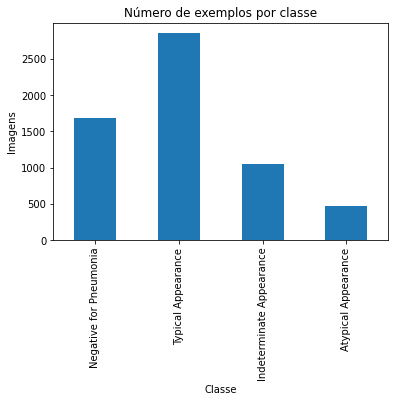

In [24]:
ax = dataset.sum()[1:-2].plot(kind='bar')
ax.set_ylabel('Imagens')
ax.set_xlabel('Classe')
ax.set_title('Número de exemplos por classe');

## Separação dos *datasets* para classificação

In [25]:
dataset1_labels = ('Typical Appearance', 'Indeterminate Appearance')
dataset2_labels = ('Typical Appearance', 'Atypical Appearance')
dataset1 = dataset[dataset[LABEL_COL_NAME].isin(dataset1_labels)]#.sort_values(by=LABEL_COL_NAME)
dataset2 = dataset[dataset[LABEL_COL_NAME].isin(dataset2_labels)]#.sort_values(by=LABEL_COL_NAME)

In [26]:
dataset1

,id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,cat,filename
0,00086460a852,0,1,0,0,Typical Appearance,Typical Appearance/00086460a852.png
7,009bc005edaa,0,0,1,0,Indeterminate Appearance,Indeterminate Appearance/009bc005edaa.png
8,00a76543ed93,0,0,1,0,Indeterminate Appearance,Indeterminate Appearance/00a76543ed93.png
9,00a87235ca36,0,1,0,0,Typical Appearance,Typical Appearance/00a87235ca36.png
10,00b33b3eb8d9,0,1,0,0,Typical Appearance,Typical Appearance/00b33b3eb8d9.png
...,...,...,...,...,...,...,...
6049,ffcb4630f46f,0,1,0,0,Typical Appearance,Typical Appearance/ffcb4630f46f.png
6050,ffe4d6e8fbb0,0,1,0,0,Typical Appearance,Typical Appearance/ffe4d6e8fbb0.png
6051,ffe94fcb14fa,0,1,0,0,Typical Appearance,Typical Appearance/ffe94fcb14fa.png
6052,ffebf1ef4a9c,0,1,0,0,Typical Appearance,Typical Appearance/ffebf1ef4a9c.png


In [27]:
dataset2

,id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,cat,filename
0,00086460a852,0,1,0,0,Typical Appearance,Typical Appearance/00086460a852.png
1,000c9c05fd14,0,0,0,1,Atypical Appearance,Atypical Appearance/000c9c05fd14.png
4,0051d9b12e72,0,0,0,1,Atypical Appearance,Atypical Appearance/0051d9b12e72.png
9,00a87235ca36,0,1,0,0,Typical Appearance,Typical Appearance/00a87235ca36.png
10,00b33b3eb8d9,0,1,0,0,Typical Appearance,Typical Appearance/00b33b3eb8d9.png
...,...,...,...,...,...,...,...
6049,ffcb4630f46f,0,1,0,0,Typical Appearance,Typical Appearance/ffcb4630f46f.png
6050,ffe4d6e8fbb0,0,1,0,0,Typical Appearance,Typical Appearance/ffe4d6e8fbb0.png
6051,ffe94fcb14fa,0,1,0,0,Typical Appearance,Typical Appearance/ffe94fcb14fa.png
6052,ffebf1ef4a9c,0,1,0,0,Typical Appearance,Typical Appearance/ffebf1ef4a9c.png


## Convertendo imagens DICOM para PNG

In [28]:
# Cria as pastas de cada categoria
if CREATE_DATASET:
    for cat in dataset.cat.values:
        cat_path = os.path.join(DATA_PATH, cat)
        if not os.path.exists(cat_path):
            os.makedirs(cat_path)

    with ZipFile(DICOM_PATH) as zf:
        dcm_files = [i for i in zf.infolist() if re.match('^train/.*\.dcm$', i.filename)]
        for info in tqdm(dcm_files):
            study = info.filename.split('/')[1]
            cat = dataset.loc[dataset.id == study, LABEL_COL_NAME].values[0]
            filename = f'{os.path.join(DATA_PATH, cat, study)}.{DATA_OUTPUT_FORMAT}'
            if not os.path.exists(filename):
                try:
                    ds = pydicom.dcmread(zf.open(info.filename))
                    pyplot.imsave(filename , ds.pixel_array, cmap='gray')
                except RuntimeError:
                    pass

## Redimensionando imagens

In [29]:
if CREATE_DATASET:
    if not os.path.exists(DATA_PATH + '_resized'):
        os.makedirs(DATA_PATH + '_resized')
    for label in tqdm(os.listdir(DATA_PATH)):
        if not os.path.exists(os.path.join(DATA_PATH + '_resized', label)):
            os.makedirs(os.path.join(DATA_PATH + '_resized', label))
        for filename in tqdm(os.listdir(os.path.join(DATA_PATH, label))):
            if filename.endswith('.png'):
                try:
                    image = Image.open(os.path.join(DATA_PATH, label, filename))
                    image.resize(TARGET_SIZE).save(os.path.join(DATA_PATH + '_resized', label, filename), DATA_OUTPUT_FORMAT, optimize=True)
                except:
                    print(filename)

# Treinamento

In [30]:
data_generator = ImageDataGenerator(rescale=1./255, shear_range=0.1, zoom_range=0.1, horizontal_flip=True)
kf = StratifiedKFold(n_splits=K_FOLDS)

In [31]:
def create_model(base_model, n_classes, name):
    base_model.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(units=1024, activation='relu'),
        Dense(units=2, activation='softmax')
    ], name=name)

    return model

In [32]:
def train(base_model, dataset, data_gen, model_name=''):
    fold_history = []
    fold_metrics = []
    fold_confusion_matrix = []
    
    for train_index, val_index in kf.split(dataset.index, y=dataset[LABEL_COL_NAME]):
        n_classes = dataset[LABEL_COL_NAME].nunique()
        model = create_model(base_model, n_classes, model_name)
        model.compile(optimizer=Adam(lr=LEARNING_RATE, beta_1=0.9, beta_2=0.999, amsgrad=False), loss=CategoricalCrossentropy(), metrics=['accuracy'])

        gen_params = {
            'directory': DATA_PATH + '_resized',
            'x_col': FILENAME_COL_NAME,
            'y_col': LABEL_COL_NAME,
            'class_mode': 'categorical',
            'color_mode': 'rgb',
            'target_size': TARGET_SIZE,
            'batch_size': BATCH_SIZE
        }

        train_df = dataset.iloc[train_index]
        train_gen = data_gen.flow_from_dataframe(train_df, **gen_params)
        val_df = dataset.iloc[val_index]
        val_gen = data_gen.flow_from_dataframe(val_df, **gen_params)
        classes = train_df[LABEL_COL_NAME].unique()
        class_weights = compute_class_weight('balanced', classes=classes, y=train_df[LABEL_COL_NAME])
        print(f'Class weights: {class_weights}')
        callbacks = CALLBACKS + [ModelCheckpoint(f'{model_name}.h5', monitor="val_accuracy", save_best_only=True)]
        fold_history.append(model.fit(train_gen,
                                      steps_per_epoch=train_gen.n // BATCH_SIZE,
                                      validation_data=val_gen,
                                      validation_steps=val_gen.n // BATCH_SIZE,
                                      epochs=EPOCHS,
                                      callbacks=callbacks,
                                      class_weight={i: w for i, w in enumerate(class_weights)}).history)
        
        y_true = val_gen.classes
        y_pred = model.predict(val_gen).argmax(axis=1)
        class_report = classification_report(y_true, y_pred, output_dict=True)
        conf_matrix = confusion_matrix(y_true, y_pred)
        
        fold_confusion_matrix.append(conf_matrix)
        
        metrics = {}
        if n_classes == 2:
            tp, tn, fp, fn = conf_matrix.ravel() 
            metrics = {
                'TP': tp,
                'TN': tn,
                'FP': fp,
                'FN': fn,
                'ACC': class_report['accuracy'],
                'SPE': class_report['0']['recall'],
                'REC': class_report['1']['recall'],
                'PRE': class_report['1']['precision'],
                'F1': class_report['1']['f1-score']
            }
        
        fold_metrics.append(metrics)
        
    return {
        'fold_history': fold_history,
        'fold_metrics': fold_metrics,
        'fold_confusion_matrix': fold_confusion_matrix
    }

In [40]:
def plot_metrics(fold, results):
    fig, ax = pyplot.subplots(2, 2, figsize=(15, 10))
    # Obtém a lista de métricas
    metric_names = next(iter(results.items()))[1]['fold_history'][0].keys()

    for i, metric_name in enumerate(metric_names):
        row = i // 2
        col = i % 2
        if metric_name.endswith('accuracy'):
            ax[row, col].set_ylim([0, 1.0])
            ax[row, col].set_ylabel('Acurácia')
        elif metric_name.endswith(''):
            ax[row, col].set_ylabel('Erro')

        for base_model_name in BASE_MODELS:
            metric_values = results[base_model_name]['fold_history'][fold - 1][metric_name]
            ax[row, col].plot(metric_values, label=base_model_name)
        ax[row, col].set_title(f'Evolução da métrica {metric_name} do fold {fold + 1}')
        ax[row, col].set_xlim([0, 4])
        ax[row, col].set_xticks(numpy.arange(0, len(metric_values)))
        ax[row, col].set_xlabel('Época')
        ax[row, col].legend()
    pyplot.tight_layout()

Treina todas as combinações de modelo pré treinado e _dataset_. Salva os resultados (histórico, matriz de confusão e métricas de classificação) num dicionário indexado pelo nome do modelo pré treinado utilizado.

In [34]:
results = []
for i, ds in enumerate([dataset1, dataset2]):
    results.append({})
    print(f'Dataset {i + 1}: {ds[LABEL_COL_NAME].unique()}')
    for base_model_name in BASE_MODELS:
        results[i][base_model_name] = train(BASE_MODELS[base_model_name], ds, data_generator, f'{base_model_name}_dataset-{i + 1}')

Dataset 1: ['Typical Appearance' 'Indeterminate Appearance']


/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 223 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 69 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 2900 validated image filenames belonging to 2 classes.
Found 712 validated image filenames belonging to 2 classes.
Class weights: [0.683669   1.86114422]
Epoch 1/30
90/90 [==============================] - 101s 1s/step - loss: 2.1800 - accuracy: 0.7230 - val_loss: 0.7100 - val_accuracy: 0.7173
Epoch 2/30
90/90 [==============================] - 97s 1s/step - loss: 0.5837 - accuracy: 0.7262 - val_loss: 0.6461 - val_accuracy: 0.7145
Epoch 3/30
90/90 [==============================] - 98s 1s/step - loss: 0.5908 - accuracy: 0.7197 - val_loss: 0.7377 - val_accuracy: 0.7173


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 244 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 48 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 2879 validated image filenames belonging to 2 classes.
Found 733 validated image filenames belonging to 2 classes.
Class weights: [0.683669   1.86114422]
Epoch 1/30
89/89 [==============================] - 100s 1s/step - loss: 3.2404 - accuracy: 0.6734 - val_loss: 0.8870 - val_accuracy: 0.7273
Epoch 2/30
89/89 [==============================] - 97s 1s/step - loss: 0.5896 - accuracy: 0.7227 - val_loss: 0.6896 - val_accuracy: 0.7259
Epoch 3/30
89/89 [==============================] - 97s 1s/step - loss: 0.5824 - accuracy: 0.7251 - val_loss: 0.6587 - val_accuracy: 0.7216


/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 231 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 61 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 2892 validated image filenames belonging to 2 classes.
Found 720 validated image filenames belonging to 2 classes.
Class weights: [0.683669   1.86114422]
Epoch 1/30
90/90 [==============================] - 101s 1s/step - loss: 3.6595 - accuracy: 0.6546 - val_loss: 0.6259 - val_accuracy: 0.7301
Epoch 2/30
90/90 [==============================] - 97s 1s/step - loss: 0.5833 - accuracy: 0.7218 - val_loss: 0.6786 - val_accuracy: 0.7259
Epoch 3/30
90/90 [==============================] - 97s 1s/step - loss: 0.5819 - accuracy: 0.7184 - val_loss: 0.7345 - val_accuracy: 0.7287


/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 234 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 58 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 2889 validated image filenames belonging to 2 classes.
Found 723 validated image filenames belonging to 2 classes.
Class weights: [0.683669   1.86114422]
Epoch 1/30
90/90 [==============================] - 100s 1s/step - loss: 1.9553 - accuracy: 0.6713 - val_loss: 0.7583 - val_accuracy: 0.7273
Epoch 2/30
90/90 [==============================] - 97s 1s/step - loss: 0.5803 - accuracy: 0.7344 - val_loss: 0.6923 - val_accuracy: 0.7259
Epoch 3/30
90/90 [==============================] - 97s 1s/step - loss: 0.5721 - accuracy: 0.7303 - val_loss: 0.6965 - val_accuracy: 0.7287
Epoch 4/30
90/90 [==============================] - 97s 1s/step - loss: 0.5775 - accuracy: 0.7276 - val_loss: 0.6686 - val_accuracy: 0.7330
Epoch 5/30
90/90 [==============================] - 97s 1s/step - loss: 0.5816 - accuracy: 0.7265 - val_loss: 0.6410 - val_accuracy: 0.7259
Epoch 6/30
90/90 [==============================] - 97s 1s/step - loss: 0.5753 - accuracy: 0.7265 - val_loss: 0.6608 - val_accuracy: 0.7259

/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 236 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 56 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 2888 validated image filenames belonging to 2 classes.
Found 724 validated image filenames belonging to 2 classes.
Class weights: [0.68388792 1.85952381]
Epoch 1/30
90/90 [==============================] - 101s 1s/step - loss: 2.3696 - accuracy: 0.6942 - val_loss: 1.0455 - val_accuracy: 0.7287
Epoch 2/30
90/90 [==============================] - 97s 1s/step - loss: 0.6333 - accuracy: 0.7124 - val_loss: 0.6672 - val_accuracy: 0.7330
Epoch 3/30
90/90 [==============================] - 97s 1s/step - loss: 0.5953 - accuracy: 0.7216 - val_loss: 0.7030 - val_accuracy: 0.7372
Epoch 4/30
90/90 [==============================] - 97s 1s/step - loss: 0.5829 - accuracy: 0.7234 - val_loss: 0.6228 - val_accuracy: 0.7344
Epoch 5/30
90/90 [==============================] - 97s 1s/step - loss: 0.5756 - accuracy: 0.7242 - val_loss: 0.6434 - val_accuracy: 0.7330


/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 223 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 69 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 2900 validated image filenames belonging to 2 classes.
Found 712 validated image filenames belonging to 2 classes.
Class weights: [0.683669   1.86114422]
Epoch 1/30
90/90 [==============================] - 72s 769ms/step - loss: 19.0128 - accuracy: 0.6565 - val_loss: 1.5675 - val_accuracy: 0.7202
Epoch 2/30
90/90 [==============================] - 68s 754ms/step - loss: 1.0602 - accuracy: 0.7089 - val_loss: 1.4630 - val_accuracy: 0.7188
Epoch 3/30
90/90 [==============================] - 68s 753ms/step - loss: 0.8108 - accuracy: 0.7310 - val_loss: 0.6120 - val_accuracy: 0.7216
Epoch 4/30
90/90 [==============================] - 68s 753ms/step - loss: 0.6749 - accuracy: 0.7084 - val_loss: 0.8665 - val_accuracy: 0.7173
Epoch 5/30
90/90 [==============================] - 68s 754ms/step - loss: 0.5702 - accuracy: 0.7210 - val_loss: 0.9959 - val_accuracy: 0.7173


/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 244 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 48 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 2879 validated image filenames belonging to 2 classes.
Found 733 validated image filenames belonging to 2 classes.
Class weights: [0.683669   1.86114422]
Epoch 1/30
89/89 [==============================] - 73s 773ms/step - loss: 9.2104 - accuracy: 0.6682 - val_loss: 0.6234 - val_accuracy: 0.7230
Epoch 2/30
89/89 [==============================] - 68s 759ms/step - loss: 0.6176 - accuracy: 0.7307 - val_loss: 0.5882 - val_accuracy: 0.7301
Epoch 3/30
89/89 [==============================] - 67s 758ms/step - loss: 0.5511 - accuracy: 0.7209 - val_loss: 0.6687 - val_accuracy: 0.7273
Epoch 4/30
89/89 [==============================] - 68s 759ms/step - loss: 0.5555 - accuracy: 0.7201 - val_loss: 0.5741 - val_accuracy: 0.7202


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 231 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 61 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 2892 validated image filenames belonging to 2 classes.
Found 720 validated image filenames belonging to 2 classes.
Class weights: [0.683669   1.86114422]
Epoch 1/30
90/90 [==============================] - 72s 769ms/step - loss: 11.2669 - accuracy: 0.6719 - val_loss: 2.3801 - val_accuracy: 0.7259
Epoch 2/30
90/90 [==============================] - 68s 754ms/step - loss: 0.8483 - accuracy: 0.7197 - val_loss: 1.3688 - val_accuracy: 0.7315
Epoch 3/30
90/90 [==============================] - 68s 753ms/step - loss: 0.5985 - accuracy: 0.7256 - val_loss: 0.5643 - val_accuracy: 0.7273
Epoch 4/30
90/90 [==============================] - 68s 754ms/step - loss: 0.5625 - accuracy: 0.7162 - val_loss: 0.7146 - val_accuracy: 0.7330
Epoch 5/30
90/90 [==============================] - 68s 752ms/step - loss: 0.5341 - accuracy: 0.7237 - val_loss: 0.6161 - val_accuracy: 0.7273
Epoch 6/30
90/90 [==============================] - 68s 752ms/step - loss: 0.5301 - accuracy: 0.7390 - val_loss: 0.7502 - va

/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 234 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 58 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 2889 validated image filenames belonging to 2 classes.
Found 723 validated image filenames belonging to 2 classes.
Class weights: [0.683669   1.86114422]
Epoch 1/30
90/90 [==============================] - 73s 768ms/step - loss: 12.2756 - accuracy: 0.6658 - val_loss: 0.5873 - val_accuracy: 0.7031
Epoch 2/30
90/90 [==============================] - 68s 753ms/step - loss: 0.6061 - accuracy: 0.7271 - val_loss: 0.5826 - val_accuracy: 0.7244
Epoch 3/30
90/90 [==============================] - 68s 752ms/step - loss: 0.5325 - accuracy: 0.7432 - val_loss: 0.6999 - val_accuracy: 0.7301
Epoch 4/30
90/90 [==============================] - 68s 757ms/step - loss: 0.5407 - accuracy: 0.7288 - val_loss: 0.6668 - val_accuracy: 0.7259
Epoch 5/30
90/90 [==============================] - 68s 752ms/step - loss: 0.5411 - accuracy: 0.7265 - val_loss: 0.6528 - val_accuracy: 0.7301


/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 236 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 56 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 2888 validated image filenames belonging to 2 classes.
Found 724 validated image filenames belonging to 2 classes.
Class weights: [0.68388792 1.85952381]
Epoch 1/30
90/90 [==============================] - 73s 776ms/step - loss: 15.1754 - accuracy: 0.6675 - val_loss: 0.6602 - val_accuracy: 0.7330
Epoch 2/30
90/90 [==============================] - 68s 753ms/step - loss: 0.7490 - accuracy: 0.7046 - val_loss: 0.8400 - val_accuracy: 0.7358
Epoch 3/30
90/90 [==============================] - 68s 752ms/step - loss: 0.5947 - accuracy: 0.7316 - val_loss: 0.7978 - val_accuracy: 0.7358
Epoch 4/30
90/90 [==============================] - 68s 751ms/step - loss: 0.5624 - accuracy: 0.7297 - val_loss: 0.5688 - val_accuracy: 0.7259


/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 223 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 69 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 2900 validated image filenames belonging to 2 classes.
Found 712 validated image filenames belonging to 2 classes.
Class weights: [0.683669   1.86114422]
Epoch 1/30
90/90 [==============================] - 168s 2s/step - loss: 2.2063 - accuracy: 0.6689 - val_loss: 0.6525 - val_accuracy: 0.7173
Epoch 2/30
90/90 [==============================] - 163s 2s/step - loss: 0.5821 - accuracy: 0.7272 - val_loss: 0.8603 - val_accuracy: 0.7202
Epoch 3/30
90/90 [==============================] - 163s 2s/step - loss: 0.5657 - accuracy: 0.7331 - val_loss: 0.8287 - val_accuracy: 0.7188
Epoch 4/30
90/90 [==============================] - 162s 2s/step - loss: 0.5896 - accuracy: 0.7269 - val_loss: 0.8628 - val_accuracy: 0.7188


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 244 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 48 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 2879 validated image filenames belonging to 2 classes.
Found 733 validated image filenames belonging to 2 classes.
Class weights: [0.683669   1.86114422]
Epoch 1/30
89/89 [==============================] - 168s 2s/step - loss: 2.2861 - accuracy: 0.6988 - val_loss: 0.6732 - val_accuracy: 0.7216
Epoch 2/30
89/89 [==============================] - 162s 2s/step - loss: 0.5881 - accuracy: 0.7168 - val_loss: 0.8304 - val_accuracy: 0.7301
Epoch 3/30
89/89 [==============================] - 163s 2s/step - loss: 0.5944 - accuracy: 0.7253 - val_loss: 0.7083 - val_accuracy: 0.7273
Epoch 4/30
89/89 [==============================] - 162s 2s/step - loss: 0.5714 - accuracy: 0.7297 - val_loss: 0.6730 - val_accuracy: 0.7259


/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 231 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 61 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 2892 validated image filenames belonging to 2 classes.
Found 720 validated image filenames belonging to 2 classes.
Class weights: [0.683669   1.86114422]
Epoch 1/30
90/90 [==============================] - 170s 2s/step - loss: 1.6596 - accuracy: 0.7010 - val_loss: 0.6985 - val_accuracy: 0.7287
Epoch 2/30
90/90 [==============================] - 166s 2s/step - loss: 0.6012 - accuracy: 0.7141 - val_loss: 0.6812 - val_accuracy: 0.7244
Epoch 3/30
90/90 [==============================] - 166s 2s/step - loss: 0.5870 - accuracy: 0.7310 - val_loss: 0.6455 - val_accuracy: 0.7330
Epoch 4/30
90/90 [==============================] - 166s 2s/step - loss: 0.5731 - accuracy: 0.7226 - val_loss: 0.6842 - val_accuracy: 0.7259
Epoch 5/30
90/90 [==============================] - 164s 2s/step - loss: 0.5754 - accuracy: 0.7263 - val_loss: 0.6028 - val_accuracy: 0.7287


/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 234 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 58 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 2889 validated image filenames belonging to 2 classes.
Found 723 validated image filenames belonging to 2 classes.
Class weights: [0.683669   1.86114422]
Epoch 1/30
90/90 [==============================] - 170s 2s/step - loss: 1.4725 - accuracy: 0.7106 - val_loss: 0.6061 - val_accuracy: 0.7330
Epoch 2/30
90/90 [==============================] - 162s 2s/step - loss: 0.6015 - accuracy: 0.7200 - val_loss: 0.6517 - val_accuracy: 0.7259
Epoch 3/30
90/90 [==============================] - 162s 2s/step - loss: 0.5830 - accuracy: 0.7289 - val_loss: 0.6506 - val_accuracy: 0.7230


/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 236 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 56 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 2888 validated image filenames belonging to 2 classes.
Found 724 validated image filenames belonging to 2 classes.
Class weights: [0.68388792 1.85952381]
Epoch 1/30
90/90 [==============================] - 168s 2s/step - loss: 1.1989 - accuracy: 0.7109 - val_loss: 0.5967 - val_accuracy: 0.7344
Epoch 2/30
90/90 [==============================] - 162s 2s/step - loss: 0.5865 - accuracy: 0.7239 - val_loss: 0.6717 - val_accuracy: 0.7287
Epoch 3/30
90/90 [==============================] - 162s 2s/step - loss: 0.5678 - accuracy: 0.7307 - val_loss: 0.7058 - val_accuracy: 0.7315


/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 223 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 69 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 2900 validated image filenames belonging to 2 classes.
Found 712 validated image filenames belonging to 2 classes.
Class weights: [0.683669   1.86114422]
Epoch 1/30
90/90 [==============================] - 136s 1s/step - loss: 13.2878 - accuracy: 0.6541 - val_loss: 0.5983 - val_accuracy: 0.7202
Epoch 2/30
90/90 [==============================] - 126s 1s/step - loss: 0.6220 - accuracy: 0.7399 - val_loss: 1.2418 - val_accuracy: 0.7202
Epoch 3/30
90/90 [==============================] - 125s 1s/step - loss: 0.6575 - accuracy: 0.7159 - val_loss: 0.6336 - val_accuracy: 0.7145


/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 244 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 48 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 2879 validated image filenames belonging to 2 classes.
Found 733 validated image filenames belonging to 2 classes.
Class weights: [0.683669   1.86114422]
Epoch 1/30
89/89 [==============================] - 136s 1s/step - loss: 19.1314 - accuracy: 0.6697 - val_loss: 0.9260 - val_accuracy: 0.7259
Epoch 2/30
89/89 [==============================] - 125s 1s/step - loss: 0.7186 - accuracy: 0.7086 - val_loss: 0.7854 - val_accuracy: 0.7230
Epoch 3/30
89/89 [==============================] - 125s 1s/step - loss: 0.6499 - accuracy: 0.7202 - val_loss: 0.8646 - val_accuracy: 0.7230


/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 231 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 61 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 2892 validated image filenames belonging to 2 classes.
Found 720 validated image filenames belonging to 2 classes.
Class weights: [0.683669   1.86114422]
Epoch 1/30
90/90 [==============================] - 137s 1s/step - loss: 12.4216 - accuracy: 0.6570 - val_loss: 4.6122 - val_accuracy: 0.7287
Epoch 2/30
90/90 [==============================] - 125s 1s/step - loss: 1.3605 - accuracy: 0.6988 - val_loss: 0.8343 - val_accuracy: 0.7259
Epoch 3/30
90/90 [==============================] - 125s 1s/step - loss: 0.6264 - accuracy: 0.7259 - val_loss: 0.5879 - val_accuracy: 0.7315
Epoch 4/30
90/90 [==============================] - 126s 1s/step - loss: 0.5522 - accuracy: 0.7325 - val_loss: 0.5620 - val_accuracy: 0.7202
Epoch 5/30
90/90 [==============================] - 125s 1s/step - loss: 0.5786 - accuracy: 0.7249 - val_loss: 0.5927 - val_accuracy: 0.7244


/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 234 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 58 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 2889 validated image filenames belonging to 2 classes.
Found 723 validated image filenames belonging to 2 classes.
Class weights: [0.683669   1.86114422]
Epoch 1/30
90/90 [==============================] - 136s 1s/step - loss: 15.6975 - accuracy: 0.6662 - val_loss: 0.6817 - val_accuracy: 0.7244
Epoch 2/30
90/90 [==============================] - 126s 1s/step - loss: 0.8269 - accuracy: 0.7102 - val_loss: 1.5029 - val_accuracy: 0.7259
Epoch 3/30
90/90 [==============================] - 125s 1s/step - loss: 0.7713 - accuracy: 0.7168 - val_loss: 0.9491 - val_accuracy: 0.7330
Epoch 4/30
90/90 [==============================] - 125s 1s/step - loss: 0.5792 - accuracy: 0.7333 - val_loss: 1.0288 - val_accuracy: 0.7273
Epoch 5/30
90/90 [==============================] - 125s 1s/step - loss: 0.5514 - accuracy: 0.7508 - val_loss: 0.7557 - val_accuracy: 0.7259


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 236 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 56 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 2888 validated image filenames belonging to 2 classes.
Found 724 validated image filenames belonging to 2 classes.
Class weights: [0.68388792 1.85952381]
Epoch 1/30
90/90 [==============================] - 135s 1s/step - loss: 15.4833 - accuracy: 0.6599 - val_loss: 0.8375 - val_accuracy: 0.5412
Epoch 2/30
90/90 [==============================] - 126s 1s/step - loss: 0.7561 - accuracy: 0.6935 - val_loss: 0.6380 - val_accuracy: 0.7330
Epoch 3/30
90/90 [==============================] - 125s 1s/step - loss: 0.5877 - accuracy: 0.7525 - val_loss: 0.8271 - val_accuracy: 0.7315
Epoch 4/30
90/90 [==============================] - 125s 1s/step - loss: 0.5488 - accuracy: 0.7385 - val_loss: 0.7101 - val_accuracy: 0.7358
Epoch 5/30
90/90 [==============================] - 125s 1s/step - loss: 0.6149 - accuracy: 0.7174 - val_loss: 0.6428 - val_accuracy: 0.7315
Epoch 6/30
90/90 [==============================] - 125s 1s/step - loss: 0.5407 - accuracy: 0.7303 - val_loss: 0.7143 - val_accuracy: 

/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 223 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 69 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 2900 validated image filenames belonging to 2 classes.
Found 712 validated image filenames belonging to 2 classes.
Class weights: [0.683669   1.86114422]
Epoch 1/30
90/90 [==============================] - 242s 3s/step - loss: 1.6316 - accuracy: 0.7058 - val_loss: 0.6282 - val_accuracy: 0.7173
Epoch 2/30
90/90 [==============================] - 232s 3s/step - loss: 0.5831 - accuracy: 0.7203 - val_loss: 0.7232 - val_accuracy: 0.7173
Epoch 3/30
90/90 [==============================] - 232s 3s/step - loss: 0.5858 - accuracy: 0.7221 - val_loss: 0.7038 - val_accuracy: 0.7202
Epoch 4/30
90/90 [==============================] - 232s 3s/step - loss: 0.5658 - accuracy: 0.7385 - val_loss: 0.6674 - val_accuracy: 0.7173
Epoch 5/30
90/90 [==============================] - 232s 3s/step - loss: 0.5719 - accuracy: 0.7314 - val_loss: 0.6987 - val_accuracy: 0.7159


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 244 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 48 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 2879 validated image filenames belonging to 2 classes.
Found 733 validated image filenames belonging to 2 classes.
Class weights: [0.683669   1.86114422]
Epoch 1/30
89/89 [==============================] - 241s 3s/step - loss: 1.7504 - accuracy: 0.6964 - val_loss: 0.6056 - val_accuracy: 0.7301
Epoch 2/30
89/89 [==============================] - 231s 3s/step - loss: 0.5674 - accuracy: 0.7413 - val_loss: 0.6638 - val_accuracy: 0.7287
Epoch 3/30
89/89 [==============================] - 230s 3s/step - loss: 0.5773 - accuracy: 0.7297 - val_loss: 0.7282 - val_accuracy: 0.7259


/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 231 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 61 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 2892 validated image filenames belonging to 2 classes.
Found 720 validated image filenames belonging to 2 classes.
Class weights: [0.683669   1.86114422]
Epoch 1/30
90/90 [==============================] - 242s 3s/step - loss: 2.0790 - accuracy: 0.6889 - val_loss: 0.6600 - val_accuracy: 0.7287
Epoch 2/30
90/90 [==============================] - 232s 3s/step - loss: 0.5723 - accuracy: 0.7356 - val_loss: 0.6366 - val_accuracy: 0.7301
Epoch 3/30
90/90 [==============================] - 232s 3s/step - loss: 0.5978 - accuracy: 0.7217 - val_loss: 0.6447 - val_accuracy: 0.7287
Epoch 4/30
90/90 [==============================] - 232s 3s/step - loss: 0.5892 - accuracy: 0.7177 - val_loss: 0.8102 - val_accuracy: 0.7287


/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 234 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 58 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 2889 validated image filenames belonging to 2 classes.
Found 723 validated image filenames belonging to 2 classes.
Class weights: [0.683669   1.86114422]
Epoch 1/30
90/90 [==============================] - 241s 3s/step - loss: 2.1164 - accuracy: 0.7108 - val_loss: 0.6700 - val_accuracy: 0.7244
Epoch 2/30
90/90 [==============================] - 232s 3s/step - loss: 0.5980 - accuracy: 0.7273 - val_loss: 0.6352 - val_accuracy: 0.7273
Epoch 3/30
90/90 [==============================] - 232s 3s/step - loss: 0.5898 - accuracy: 0.7290 - val_loss: 0.7385 - val_accuracy: 0.7244
Epoch 4/30
90/90 [==============================] - 232s 3s/step - loss: 0.6085 - accuracy: 0.7103 - val_loss: 0.6181 - val_accuracy: 0.7244


/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 236 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 56 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 2888 validated image filenames belonging to 2 classes.
Found 724 validated image filenames belonging to 2 classes.
Class weights: [0.68388792 1.85952381]
Epoch 1/30
90/90 [==============================] - 241s 3s/step - loss: 1.9480 - accuracy: 0.6740 - val_loss: 0.5855 - val_accuracy: 0.7344
Epoch 2/30
90/90 [==============================] - 232s 3s/step - loss: 0.5918 - accuracy: 0.7334 - val_loss: 0.6338 - val_accuracy: 0.7259
Epoch 3/30
90/90 [==============================] - 233s 3s/step - loss: 0.5789 - accuracy: 0.7275 - val_loss: 0.5984 - val_accuracy: 0.7415
Epoch 4/30
90/90 [==============================] - 235s 3s/step - loss: 0.5740 - accuracy: 0.7310 - val_loss: 0.6607 - val_accuracy: 0.7358
Epoch 5/30
90/90 [==============================] - 231s 3s/step - loss: 0.5733 - accuracy: 0.7260 - val_loss: 0.6077 - val_accuracy: 0.7344
Dataset 2: ['Typical Appearance' 'Atypical Appearance']


/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 183 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 64 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 2480 validated image filenames belonging to 2 classes.
Found 602 validated image filenames belonging to 2 classes.
Class weights: [3.51319261 0.58296848]
Epoch 1/30
77/77 [==============================] - 86s 1s/step - loss: 2.1049 - accuracy: 0.4112 - val_loss: 0.7086 - val_accuracy: 0.1510
Epoch 2/30
77/77 [==============================] - 83s 1s/step - loss: 0.7216 - accuracy: 0.2022 - val_loss: 0.6666 - val_accuracy: 0.8542
Epoch 3/30
77/77 [==============================] - 83s 1s/step - loss: 0.7145 - accuracy: 0.6994 - val_loss: 0.6871 - val_accuracy: 0.8524
Epoch 4/30
77/77 [==============================] - 83s 1s/step - loss: 0.7174 - accuracy: 0.4335 - val_loss: 0.7083 - val_accuracy: 0.1528


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 204 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 43 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 2459 validated image filenames belonging to 2 classes.
Found 623 validated image filenames belonging to 2 classes.
Class weights: [0.58296848 3.51319261]
Epoch 1/30
76/76 [==============================] - 87s 1s/step - loss: 7.4442 - accuracy: 0.7872 - val_loss: 9.9802 - val_accuracy: 0.8536
Epoch 2/30
76/76 [==============================] - 83s 1s/step - loss: 2.2299 - accuracy: 0.8335 - val_loss: 0.4173 - val_accuracy: 0.8487
Epoch 3/30
76/76 [==============================] - 83s 1s/step - loss: 1.9457 - accuracy: 0.8395 - val_loss: 2.0784 - val_accuracy: 0.8536


/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 197 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 50 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 2466 validated image filenames belonging to 2 classes.
Found 616 validated image filenames belonging to 2 classes.
Class weights: [0.58296848 3.51319261]
Epoch 1/30
77/77 [==============================] - 86s 1s/step - loss: 4.9418 - accuracy: 0.8478 - val_loss: 0.4212 - val_accuracy: 0.8503
Epoch 2/30
77/77 [==============================] - 83s 1s/step - loss: 0.4823 - accuracy: 0.8433 - val_loss: 1.0234 - val_accuracy: 0.8503
Epoch 3/30
77/77 [==============================] - 83s 1s/step - loss: 0.8773 - accuracy: 0.8570 - val_loss: 1.1457 - val_accuracy: 0.8520
Epoch 4/30
77/77 [==============================] - 83s 1s/step - loss: 0.5865 - accuracy: 0.8381 - val_loss: 0.4137 - val_accuracy: 0.8520
Epoch 5/30
77/77 [==============================] - 83s 1s/step - loss: 0.4733 - accuracy: 0.8509 - val_loss: 0.4995 - val_accuracy: 0.8520


/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 200 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 47 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 2463 validated image filenames belonging to 2 classes.
Found 619 validated image filenames belonging to 2 classes.
Class weights: [0.58296848 3.51319261]
Epoch 1/30
76/76 [==============================] - 87s 1s/step - loss: 6.9495 - accuracy: 0.7801 - val_loss: 11.2785 - val_accuracy: 0.8520
Epoch 2/30
76/76 [==============================] - 83s 1s/step - loss: 4.2082 - accuracy: 0.8295 - val_loss: 1.3858 - val_accuracy: 0.8487
Epoch 3/30
76/76 [==============================] - 83s 1s/step - loss: 1.1659 - accuracy: 0.8422 - val_loss: 11.4948 - val_accuracy: 0.8503
Found 2460 validated image filenames belonging to 2 classes.
Found 622 validated image filenames belonging to 2 classes.
Class weights: [0.58318739 3.50526316]
Epoch 1/30
76/76 [==============================] - 86s 1s/step - loss: 8.2265 - accuracy: 0.8092 - val_loss: 0.7972 - val_accuracy: 0.8553
Epoch 2/30
76/76 [==============================] - 83s 1s/step - loss: 0.4472 - accuracy: 0.8556 - val_loss: 0.4371 -

/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 183 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 64 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 2480 validated image filenames belonging to 2 classes.
Found 602 validated image filenames belonging to 2 classes.
Class weights: [3.51319261 0.58296848]
Epoch 1/30
77/77 [==============================] - 62s 764ms/step - loss: 17.4955 - accuracy: 0.4805 - val_loss: 0.6385 - val_accuracy: 0.6944
Epoch 2/30
77/77 [==============================] - 58s 747ms/step - loss: 0.6957 - accuracy: 0.6480 - val_loss: 0.8212 - val_accuracy: 0.2986
Epoch 3/30
77/77 [==============================] - 58s 746ms/step - loss: 0.6925 - accuracy: 0.4966 - val_loss: 0.8565 - val_accuracy: 0.2604


/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 204 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 43 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 2459 validated image filenames belonging to 2 classes.
Found 623 validated image filenames belonging to 2 classes.
Class weights: [0.58296848 3.51319261]
Epoch 1/30
76/76 [==============================] - 62s 779ms/step - loss: 41.8573 - accuracy: 0.7578 - val_loss: 5.4096 - val_accuracy: 0.8553
Epoch 2/30
76/76 [==============================] - 58s 758ms/step - loss: 19.2184 - accuracy: 0.8292 - val_loss: 18.3579 - val_accuracy: 0.8553
Epoch 3/30
76/76 [==============================] - 58s 758ms/step - loss: 12.1112 - accuracy: 0.8134 - val_loss: 1.6048 - val_accuracy: 0.8470


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 197 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 50 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 2466 validated image filenames belonging to 2 classes.
Found 616 validated image filenames belonging to 2 classes.
Class weights: [0.58296848 3.51319261]
Epoch 1/30
77/77 [==============================] - 62s 769ms/step - loss: 70.8973 - accuracy: 0.7694 - val_loss: 18.7995 - val_accuracy: 0.8520
Epoch 2/30
77/77 [==============================] - 58s 752ms/step - loss: 14.9316 - accuracy: 0.8416 - val_loss: 47.0353 - val_accuracy: 0.8520
Epoch 3/30
77/77 [==============================] - 58s 753ms/step - loss: 16.1403 - accuracy: 0.8496 - val_loss: 1.5353 - val_accuracy: 0.8536
Epoch 4/30
77/77 [==============================] - 58s 752ms/step - loss: 2.0763 - accuracy: 0.8320 - val_loss: 5.7373 - val_accuracy: 0.8503
Epoch 5/30
77/77 [==============================] - 58s 755ms/step - loss: 4.2643 - accuracy: 0.8401 - val_loss: 18.4804 - val_accuracy: 0.8553
Epoch 6/30
77/77 [==============================] - 58s 752ms/step - loss: 4.3404 - accuracy: 0.8494 - val_loss: 0.6494

/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 200 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 47 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 2463 validated image filenames belonging to 2 classes.
Found 619 validated image filenames belonging to 2 classes.
Class weights: [0.58296848 3.51319261]
Epoch 1/30
76/76 [==============================] - 62s 777ms/step - loss: 26.7332 - accuracy: 0.8073 - val_loss: 58.9021 - val_accuracy: 0.8487
Epoch 2/30
76/76 [==============================] - 58s 760ms/step - loss: 30.3529 - accuracy: 0.8288 - val_loss: 15.4900 - val_accuracy: 0.8503
Epoch 3/30
76/76 [==============================] - 58s 760ms/step - loss: 5.8509 - accuracy: 0.8343 - val_loss: 55.3251 - val_accuracy: 0.8470
Epoch 4/30
76/76 [==============================] - 58s 758ms/step - loss: 17.0838 - accuracy: 0.8439 - val_loss: 1.8564 - val_accuracy: 0.8470
Found 2460 validated image filenames belonging to 2 classes.
Found 622 validated image filenames belonging to 2 classes.
Class weights: [0.58318739 3.50526316]
Epoch 1/30
76/76 [==============================] - 63s 787ms/step - loss: 21.9329 - accuracy: 0.8136 

/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 183 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 64 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 2480 validated image filenames belonging to 2 classes.
Found 602 validated image filenames belonging to 2 classes.
Class weights: [3.51319261 0.58296848]
Epoch 1/30
77/77 [==============================] - 143s 2s/step - loss: 2.1079 - accuracy: 0.4462 - val_loss: 0.5840 - val_accuracy: 0.8455
Epoch 2/30
77/77 [==============================] - 137s 2s/step - loss: 0.7030 - accuracy: 0.2517 - val_loss: 0.7102 - val_accuracy: 0.1510
Epoch 3/30
77/77 [==============================] - 137s 2s/step - loss: 0.6934 - accuracy: 0.2887 - val_loss: 0.7233 - val_accuracy: 0.1510


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 204 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 43 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 2459 validated image filenames belonging to 2 classes.
Found 623 validated image filenames belonging to 2 classes.
Class weights: [0.58296848 3.51319261]
Epoch 1/30
76/76 [==============================] - 145s 2s/step - loss: 5.3522 - accuracy: 0.8251 - val_loss: 1.3415 - val_accuracy: 0.8536
Epoch 2/30
76/76 [==============================] - 138s 2s/step - loss: 0.5427 - accuracy: 0.8551 - val_loss: 0.6013 - val_accuracy: 0.8536
Epoch 3/30
76/76 [==============================] - 137s 2s/step - loss: 0.6440 - accuracy: 0.8545 - val_loss: 0.9293 - val_accuracy: 0.8569
Epoch 4/30
76/76 [==============================] - 138s 2s/step - loss: 0.5393 - accuracy: 0.8599 - val_loss: 0.7715 - val_accuracy: 0.8503
Epoch 5/30
76/76 [==============================] - 138s 2s/step - loss: 0.4641 - accuracy: 0.8476 - val_loss: 0.5707 - val_accuracy: 0.8536


/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 197 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 50 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 2466 validated image filenames belonging to 2 classes.
Found 616 validated image filenames belonging to 2 classes.
Class weights: [0.58296848 3.51319261]
Epoch 1/30
77/77 [==============================] - 145s 2s/step - loss: 4.9141 - accuracy: 0.7993 - val_loss: 10.4926 - val_accuracy: 0.8536
Epoch 2/30
77/77 [==============================] - 138s 2s/step - loss: 2.3280 - accuracy: 0.8537 - val_loss: 0.9881 - val_accuracy: 0.8520
Epoch 3/30
77/77 [==============================] - 138s 2s/step - loss: 1.2329 - accuracy: 0.8423 - val_loss: 0.4185 - val_accuracy: 0.8503


/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 200 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 47 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 2463 validated image filenames belonging to 2 classes.
Found 619 validated image filenames belonging to 2 classes.
Class weights: [0.58296848 3.51319261]
Epoch 1/30
76/76 [==============================] - 144s 2s/step - loss: 5.6185 - accuracy: 0.7782 - val_loss: 10.1058 - val_accuracy: 0.8503
Epoch 2/30
76/76 [==============================] - 138s 2s/step - loss: 3.5097 - accuracy: 0.8297 - val_loss: 0.4379 - val_accuracy: 0.8355
Epoch 3/30
76/76 [==============================] - 138s 2s/step - loss: 0.6638 - accuracy: 0.8565 - val_loss: 0.4994 - val_accuracy: 0.8470
Found 2460 validated image filenames belonging to 2 classes.
Found 622 validated image filenames belonging to 2 classes.
Class weights: [0.58318739 3.50526316]
Epoch 1/30
76/76 [==============================] - 143s 2s/step - loss: 6.4025 - accuracy: 0.7736 - val_loss: 13.2266 - val_accuracy: 0.8536
Epoch 2/30
76/76 [==============================] - 138s 2s/step - loss: 4.3240 - accuracy: 0.8251 - val_loss: 0.9

/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 183 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 64 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 2480 validated image filenames belonging to 2 classes.
Found 602 validated image filenames belonging to 2 classes.
Class weights: [3.51319261 0.58296848]
Epoch 1/30
77/77 [==============================] - 117s 1s/step - loss: 19.5420 - accuracy: 0.5340 - val_loss: 0.4914 - val_accuracy: 0.8212
Epoch 2/30
77/77 [==============================] - 106s 1s/step - loss: 0.7670 - accuracy: 0.5690 - val_loss: 0.9086 - val_accuracy: 0.3125
Epoch 3/30
77/77 [==============================] - 106s 1s/step - loss: 0.6558 - accuracy: 0.6355 - val_loss: 0.4447 - val_accuracy: 0.8472
Epoch 4/30
77/77 [==============================] - 106s 1s/step - loss: 0.6663 - accuracy: 0.6377 - val_loss: 0.8187 - val_accuracy: 0.3785
Epoch 5/30
77/77 [==============================] - 106s 1s/step - loss: 0.6395 - accuracy: 0.6396 - val_loss: 0.7079 - val_accuracy: 0.5017


/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 204 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 43 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 2459 validated image filenames belonging to 2 classes.
Found 623 validated image filenames belonging to 2 classes.
Class weights: [0.58296848 3.51319261]
Epoch 1/30
76/76 [==============================] - 118s 1s/step - loss: 56.3557 - accuracy: 0.7757 - val_loss: 80.7265 - val_accuracy: 0.8520
Epoch 2/30
76/76 [==============================] - 106s 1s/step - loss: 29.2902 - accuracy: 0.8299 - val_loss: 14.0576 - val_accuracy: 0.8536
Epoch 3/30
76/76 [==============================] - 106s 1s/step - loss: 10.9335 - accuracy: 0.8338 - val_loss: 110.5601 - val_accuracy: 0.8536
Epoch 4/30
76/76 [==============================] - 106s 1s/step - loss: 33.5470 - accuracy: 0.8457 - val_loss: 20.9944 - val_accuracy: 0.8569
Epoch 5/30
76/76 [==============================] - 106s 1s/step - loss: 7.4258 - accuracy: 0.8520 - val_loss: 8.3557 - val_accuracy: 0.8520
Epoch 6/30
76/76 [==============================] - 106s 1s/step - loss: 5.9136 - accuracy: 0.8394 - val_loss: 63.9462 - val_a

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 197 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 50 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 2466 validated image filenames belonging to 2 classes.
Found 616 validated image filenames belonging to 2 classes.
Class weights: [0.58296848 3.51319261]
Epoch 1/30
77/77 [==============================] - 118s 1s/step - loss: 38.1521 - accuracy: 0.7817 - val_loss: 31.9920 - val_accuracy: 0.8520
Epoch 2/30
77/77 [==============================] - 107s 1s/step - loss: 46.2110 - accuracy: 0.8249 - val_loss: 20.1306 - val_accuracy: 0.8536
Epoch 3/30
77/77 [==============================] - 109s 1s/step - loss: 8.8184 - accuracy: 0.8448 - val_loss: 14.6822 - val_accuracy: 0.8520
Epoch 4/30
77/77 [==============================] - 109s 1s/step - loss: 5.8396 - accuracy: 0.8378 - val_loss: 9.8878 - val_accuracy: 0.8536


/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 200 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 47 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 2463 validated image filenames belonging to 2 classes.
Found 619 validated image filenames belonging to 2 classes.
Class weights: [0.58296848 3.51319261]
Epoch 1/30
76/76 [==============================] - 120s 1s/step - loss: 43.8539 - accuracy: 0.7720 - val_loss: 14.5753 - val_accuracy: 0.8520
Epoch 2/30
76/76 [==============================] - 109s 1s/step - loss: 42.4750 - accuracy: 0.8125 - val_loss: 5.7577 - val_accuracy: 0.8487
Epoch 3/30
76/76 [==============================] - 109s 1s/step - loss: 3.7191 - accuracy: 0.8260 - val_loss: 4.0713 - val_accuracy: 0.8503
Found 2460 validated image filenames belonging to 2 classes.
Found 622 validated image filenames belonging to 2 classes.
Class weights: [0.58318739 3.50526316]
Epoch 1/30
76/76 [==============================] - 118s 1s/step - loss: 26.6916 - accuracy: 0.7901 - val_loss: 5.0370 - val_accuracy: 0.8520
Epoch 2/30
76/76 [==============================] - 107s 1s/step - loss: 7.1343 - accuracy: 0.8435 - val_loss: 1

/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 183 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 64 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 2480 validated image filenames belonging to 2 classes.
Found 602 validated image filenames belonging to 2 classes.
Class weights: [3.51319261 0.58296848]
Epoch 1/30
77/77 [==============================] - 206s 3s/step - loss: 2.7521 - accuracy: 0.5243 - val_loss: 0.8983 - val_accuracy: 0.1441
Epoch 2/30
77/77 [==============================] - 198s 3s/step - loss: 0.7126 - accuracy: 0.4326 - val_loss: 0.7579 - val_accuracy: 0.1545
Epoch 3/30
77/77 [==============================] - 197s 3s/step - loss: 0.6881 - accuracy: 0.3261 - val_loss: 0.7154 - val_accuracy: 0.1458
Epoch 4/30
77/77 [==============================] - 198s 3s/step - loss: 0.7150 - accuracy: 0.1681 - val_loss: 0.7148 - val_accuracy: 0.1476


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 204 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 43 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 2459 validated image filenames belonging to 2 classes.
Found 623 validated image filenames belonging to 2 classes.
Class weights: [0.58296848 3.51319261]
Epoch 1/30
76/76 [==============================] - 206s 3s/step - loss: 4.5613 - accuracy: 0.8296 - val_loss: 0.6487 - val_accuracy: 0.8536
Epoch 2/30
76/76 [==============================] - 197s 3s/step - loss: 0.3910 - accuracy: 0.8596 - val_loss: 0.5853 - val_accuracy: 0.8520
Epoch 3/30
76/76 [==============================] - 198s 3s/step - loss: 0.3806 - accuracy: 0.8642 - val_loss: 0.6083 - val_accuracy: 0.8536


/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 197 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 50 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 2466 validated image filenames belonging to 2 classes.
Found 616 validated image filenames belonging to 2 classes.
Class weights: [0.58296848 3.51319261]
Epoch 1/30
77/77 [==============================] - 207s 3s/step - loss: 1.4262 - accuracy: 0.8457 - val_loss: 0.4937 - val_accuracy: 0.8520
Epoch 2/30
77/77 [==============================] - 199s 3s/step - loss: 0.4168 - accuracy: 0.8479 - val_loss: 0.5908 - val_accuracy: 0.8520
Epoch 3/30
77/77 [==============================] - 198s 3s/step - loss: 0.3859 - accuracy: 0.8627 - val_loss: 0.5437 - val_accuracy: 0.8520


/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 200 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 47 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 2463 validated image filenames belonging to 2 classes.
Found 619 validated image filenames belonging to 2 classes.
Class weights: [0.58296848 3.51319261]
Epoch 1/30
76/76 [==============================] - 207s 3s/step - loss: 2.7675 - accuracy: 0.8350 - val_loss: 1.5372 - val_accuracy: 0.8503
Epoch 2/30
76/76 [==============================] - 198s 3s/step - loss: 0.7998 - accuracy: 0.8447 - val_loss: 0.5249 - val_accuracy: 0.8487
Epoch 3/30
76/76 [==============================] - 198s 3s/step - loss: 0.3883 - accuracy: 0.8640 - val_loss: 0.4364 - val_accuracy: 0.8503
Found 2460 validated image filenames belonging to 2 classes.
Found 622 validated image filenames belonging to 2 classes.
Class weights: [0.58318739 3.50526316]
Epoch 1/30
76/76 [==============================] - 207s 3s/step - loss: 8.2402 - accuracy: 0.7908 - val_loss: 3.4386 - val_accuracy: 0.8503
Epoch 2/30
76/76 [==============================] - 198s 3s/step - loss: 0.7132 - accuracy: 0.8634 - val_loss: 0.670

Plota o histórico das métricas de cada treinamento

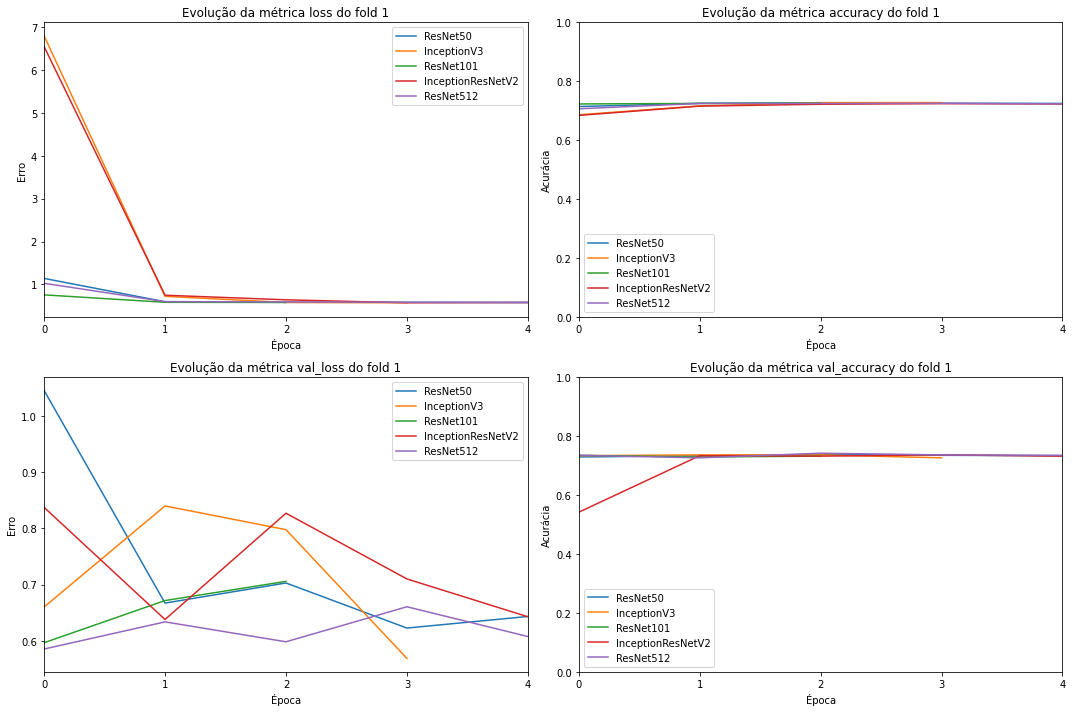

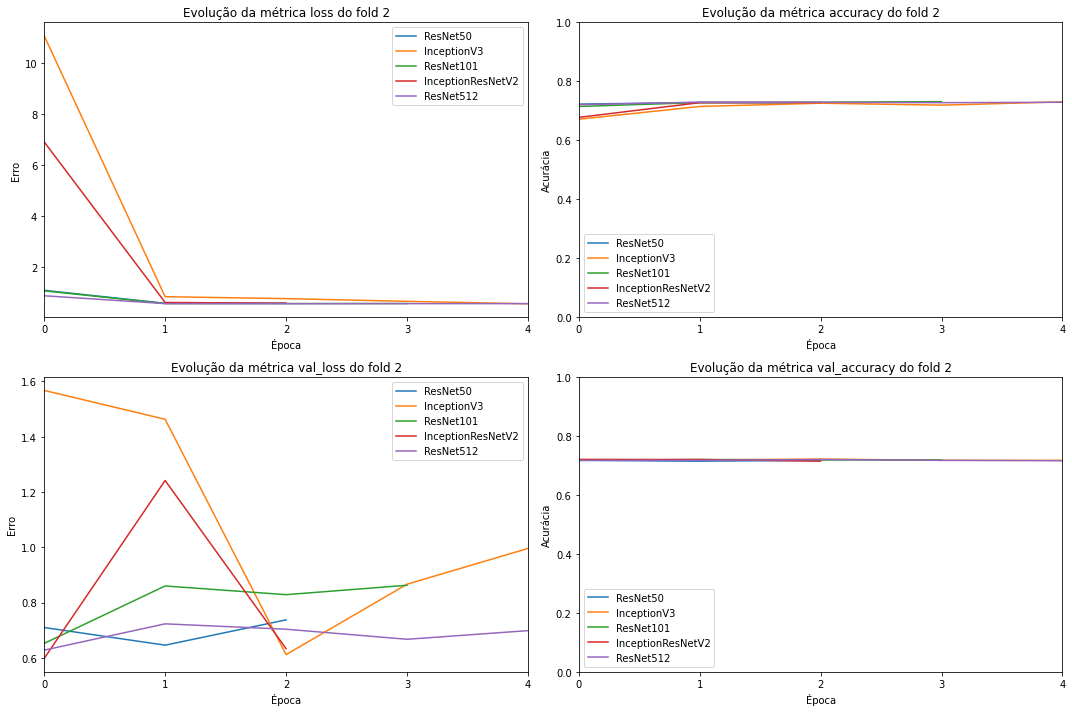

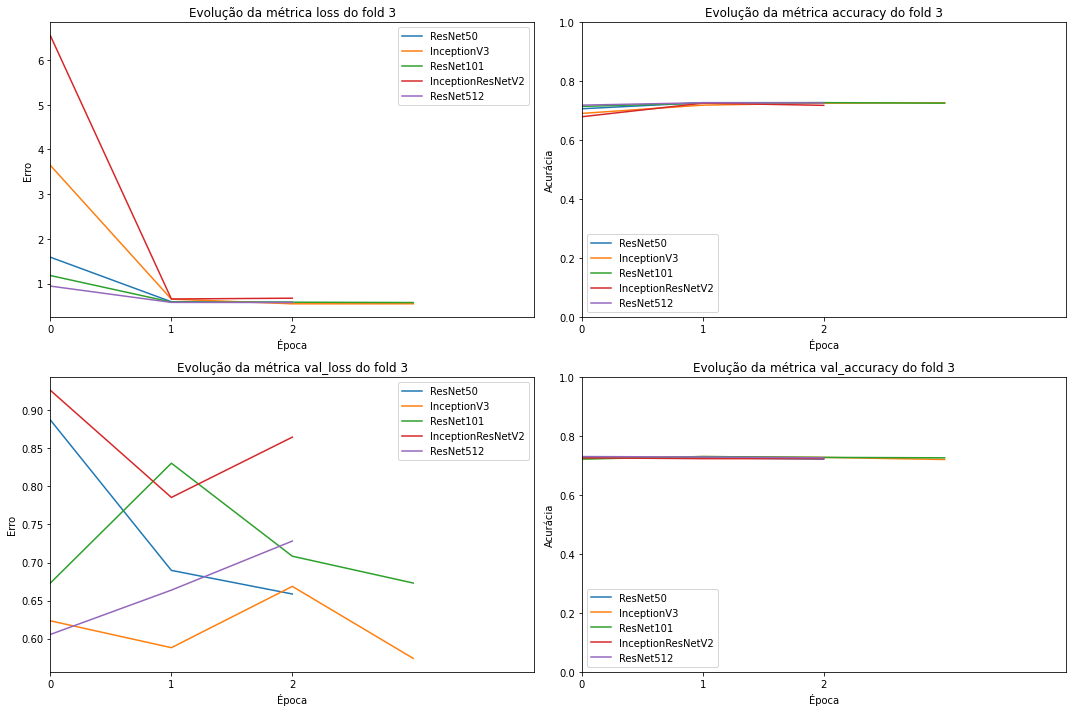

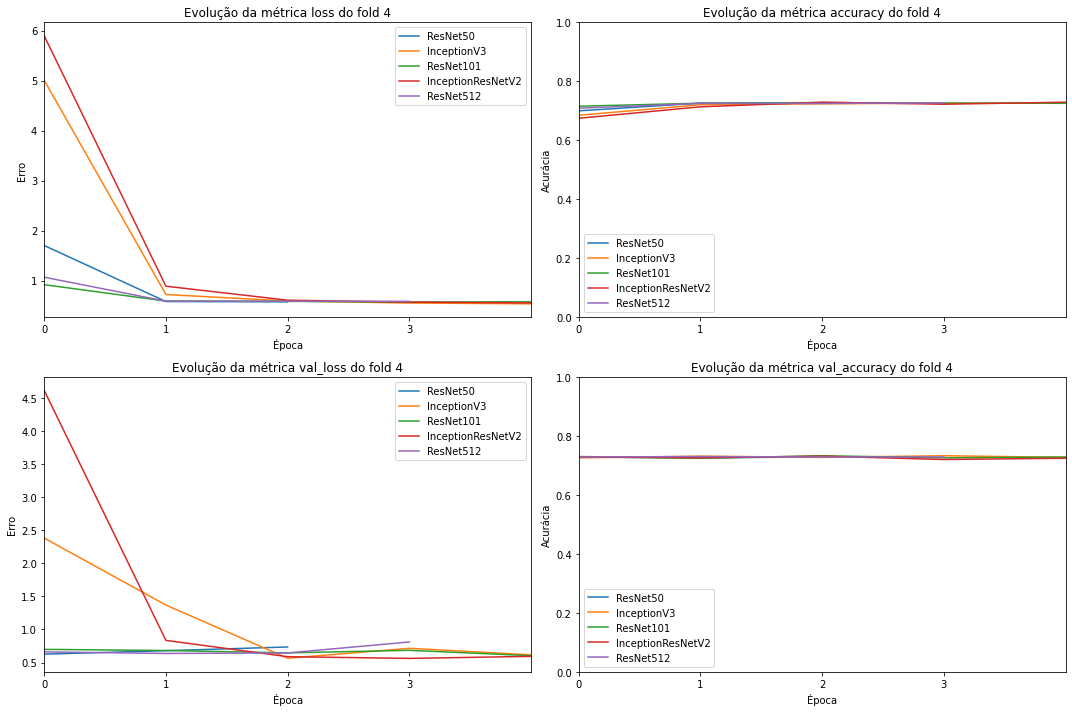

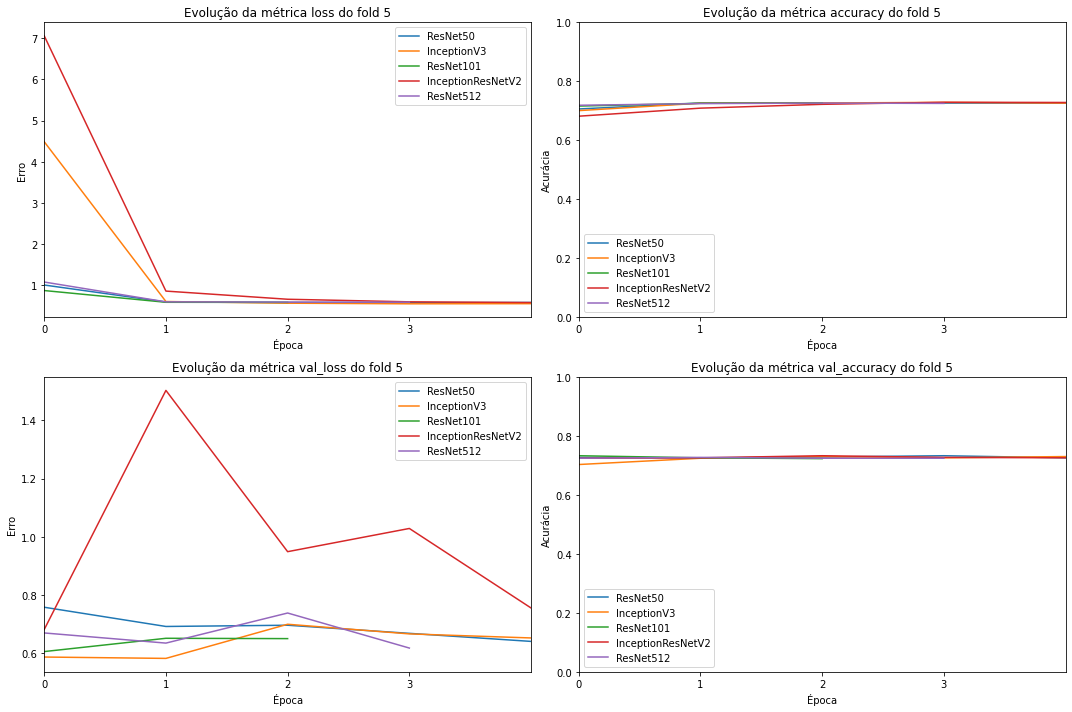

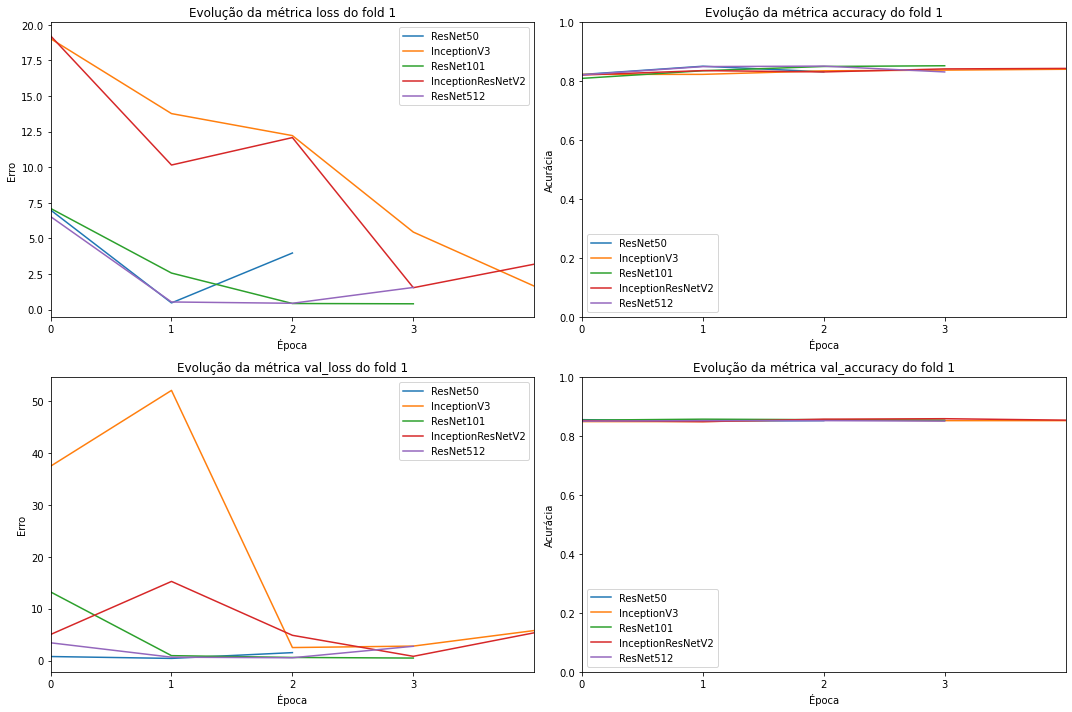

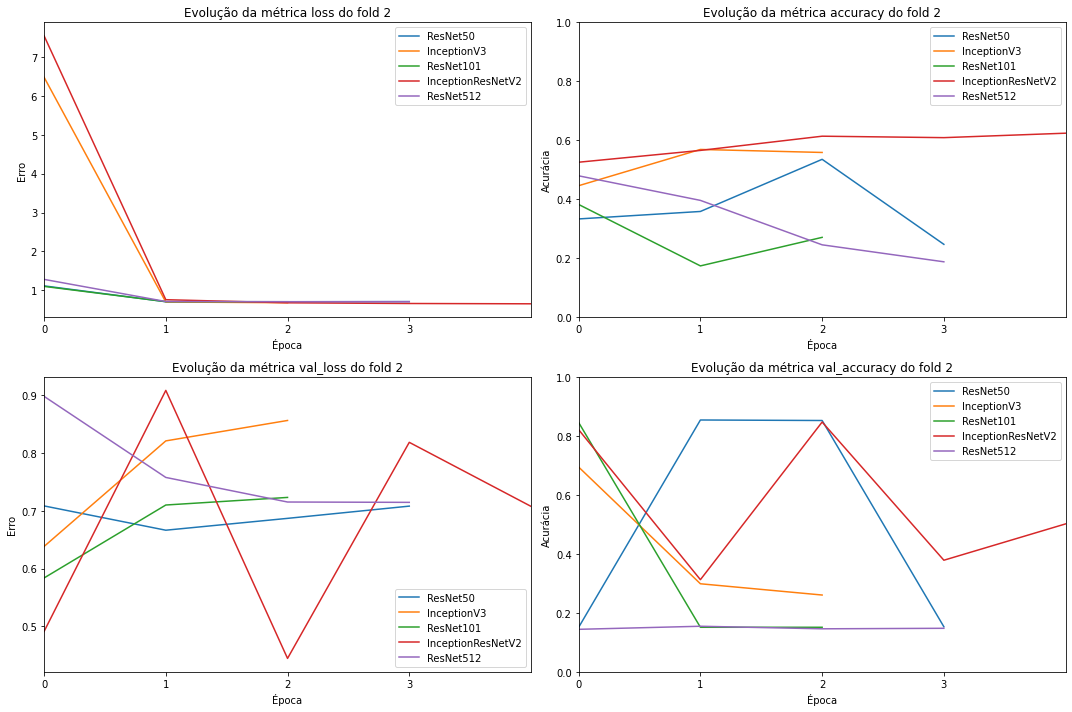

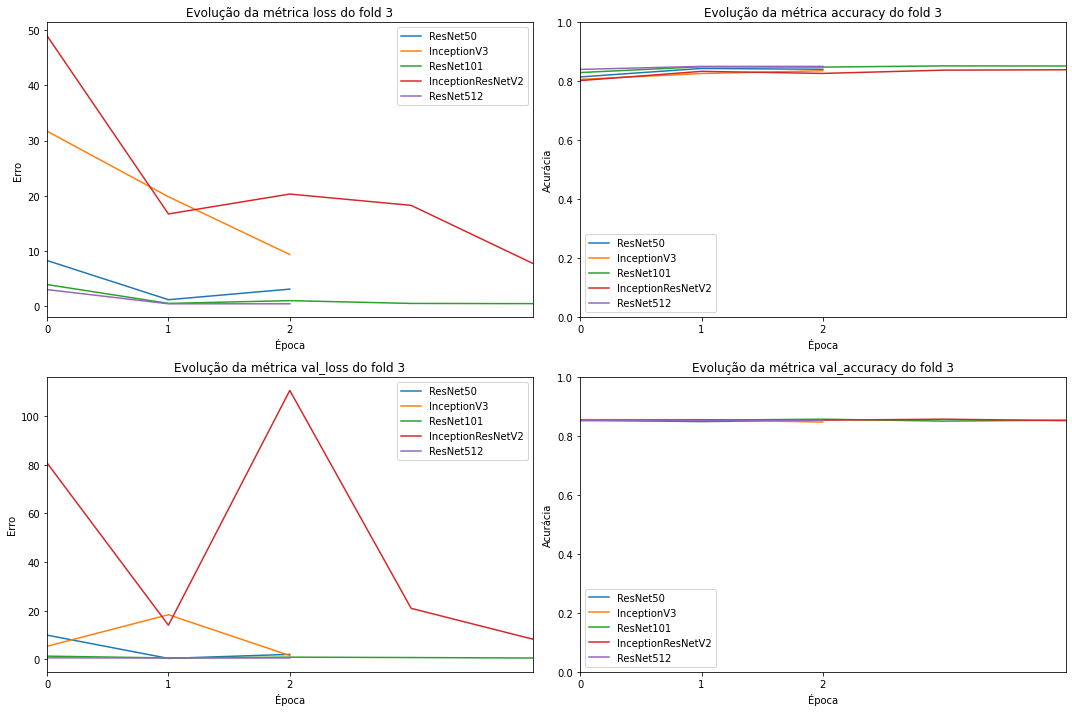

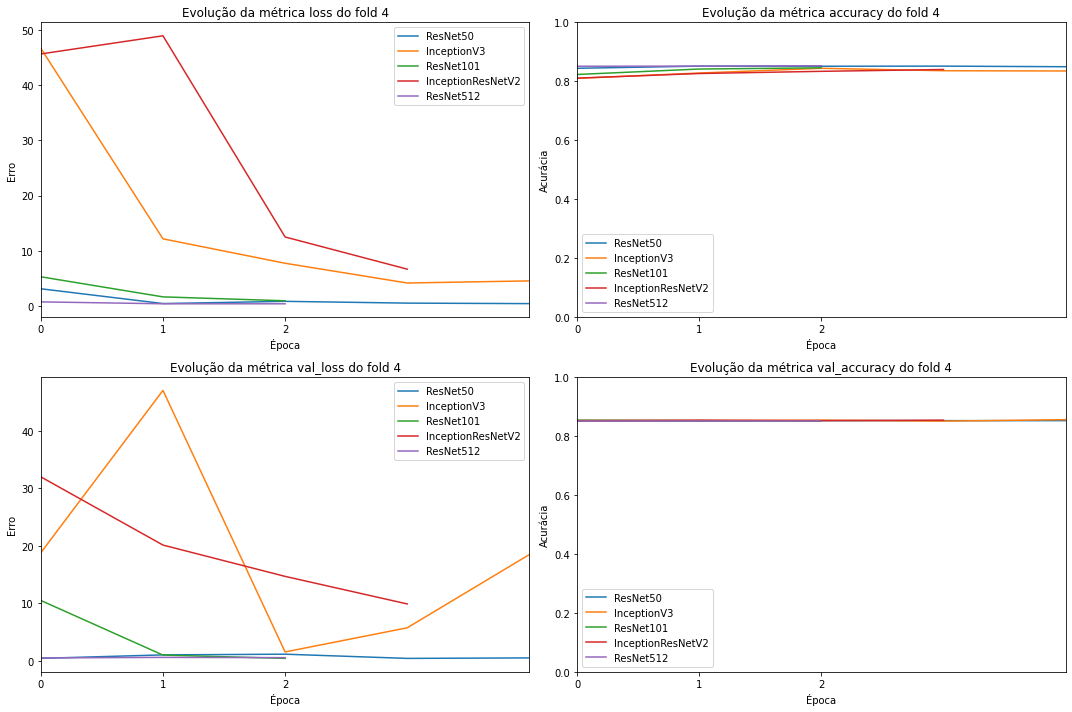

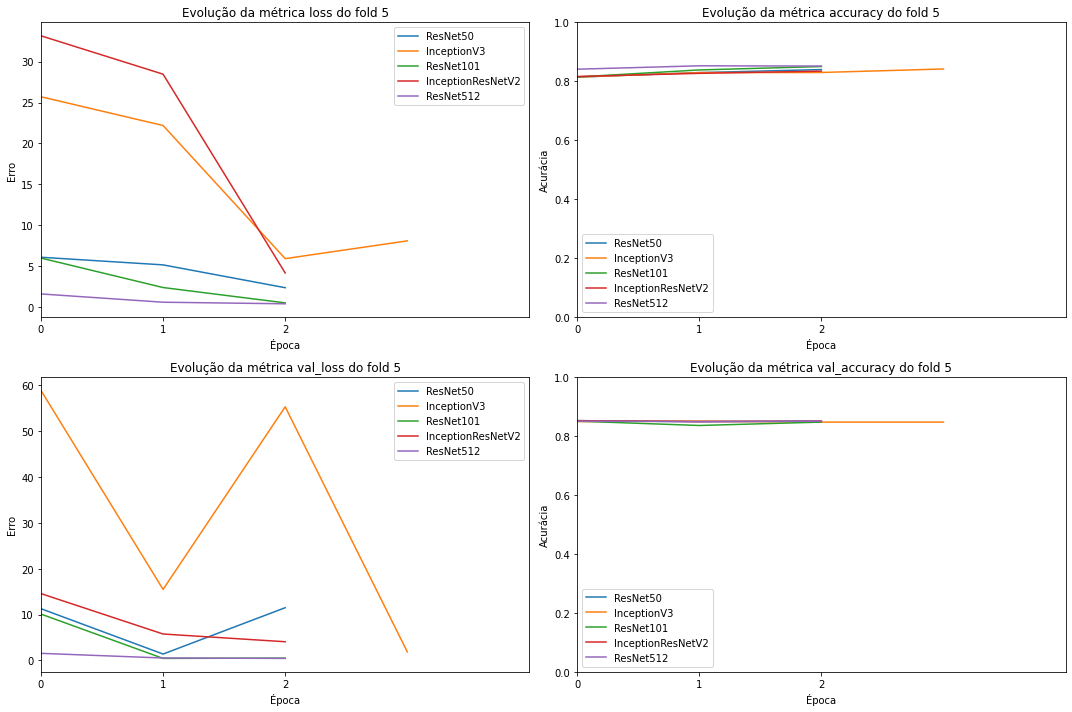

In [90]:
for i, ds in enumerate([dataset1, dataset2]):
    for fold in range(K_FOLDS):
        plot_metrics(fold, results[i])

## Resultados

Cria a tabela com os resultados obtidos, indexada pelo modelo pré-treinado utilizado e o *fold*. As colunas são:
*   **TP**: Verdadeiros positivos
*   **TN**: Verdadeiros negativos
*   **FP**: Falsos positivos
*   **FN**: Falsos negativos
*   **ACC**: Acurácia. (TP + TN) / (TP + TN + FP + FN)
*   **SPE**: Especificidade. Cobertura da classe negativa. TN / (TN + FP)
*   **REC**: Cobertura. TP / (TP + FN)
*   **PRE**: Precisão. TP / (TP + FP)
*   **F1**: Pontuação F1. 2 * (PRE * REC) / (PRE + REC)

In [87]:
def get_report(models, r):
    total_columns = ['TP', 'TN', 'FP', 'FN']
    average_columns = ['ACC', 'SPE', 'REC', 'PRE', 'F1']
    
    data = {}
    
    for model in models:
        for f in range(K_FOLDS):
            data[(model, f'Fold-{f + 1}')] = r[model]['fold_metrics'][f]
        data[(model, 'Total/average')] = {}
        for m in total_columns:
            data[(model, 'Total/average')][m] = sum([r[model]['fold_metrics'][f][m] for f in range(K_FOLDS)])
        for m in average_columns:
            data[(model, 'Total/average')][m] = numpy.average([r[model]['fold_metrics'][f][m] for f in range(K_FOLDS)])
    return DataFrame.from_dict(data).swapaxes(0, 1)

In [88]:
reports = [get_report(BASE_MODELS, result) for result in results]

In [89]:
for i, report in enumerate(reports):
    print(f'Dataset {i + 1}')
    print(report)

Dataset 1
                                   TP     TN    FP      FN       ACC  \
ResNet50          Fold-1          0.0  201.0   0.0   511.0  0.717697   
                  Fold-2          0.0  201.0   0.0   532.0  0.725784   
                  Fold-3          0.0  195.0   0.0   525.0  0.729167   
                  Fold-4          0.0  197.0   0.0   526.0  0.727524   
                  Fold-5          0.0  194.0   0.0   530.0  0.732044   
                  Total/average   0.0  988.0   0.0  2624.0  0.726443   
InceptionV3       Fold-1         11.0  190.0  33.0   478.0  0.686798   
                  Fold-2          0.0  201.0   0.0   532.0  0.725784   
                  Fold-3          0.0  195.0   0.0   525.0  0.729167   
                  Fold-4          0.0  197.0   0.0   526.0  0.727524   
                  Fold-5          0.0  194.0   0.0   530.0  0.732044   
                  Total/average  11.0  977.0  33.0  2591.0  0.720263   
ResNet101         Fold-1          0.0  201.0   0.0   5

In [54]:
def plot_confusion_matrix(results_list, base_model_name, fold, dataset):
    m = results_list[base_model_name]['fold_confusion_matrix'][fold]
    names = sorted(dataset[LABEL_COL_NAME].unique())
    
    pyplot.ylabel('Classificação verdadeira')
    pyplot.xlabel('Classificação prevista')
    pyplot.xticks(numpy.arange(len(names)), names, rotation=90)
    pyplot.yticks(numpy.arange(len(names)), names)
    pyplot.imshow(100 * m.astype('float') / m.sum(axis=1)[:, numpy.newaxis])
    pyplot.colorbar(format=ticker.PercentFormatter())

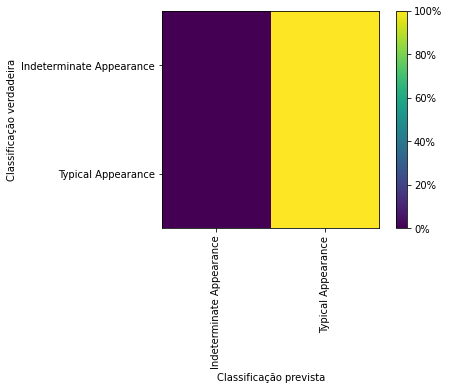

In [91]:
plot_confusion_matrix(results[1], 'InceptionV3', 1, dataset1)

# Referências

* **NARIN, Ali; KAYA, Ceren; PAMUK, Ziynet. Automatic detection of coronavirus disease (COVID-19) using X-ray images and deep convolutional neural networks.** Pattern Analysis And Applications, [S.L.], v. 24, n. 3, p. 1207-1220, 9 maio 2021. Springer Science and Business Media LLC.
*   **How to implement K-Fold Cross validation using Image data generator and using Flow from dataframe (using CSV file)**. Disponível em https://stackoverflow.com/questions/64684789/how-to-implement-k-fold-cross-validation-using-image-data-generator-and-using-fl. Acessado em 15 de setembro de 2021.
*   **Selecting multiple columns in a Pandas dataframe**. Disponível em: https://stackoverflow.com/questions/11285613/selecting-multiple-columns-in-a-pandas-dataframe. Acessado em 16 de setembro de 2021
*   **How to install pydicom**. Disponível em: https://pydicom.github.io/pydicom/stable/tutorials/installation.html. Acessado em 16 de setembro de 2021.
*   **MultiIndex / advanced indexing**. Disponível em: https://pandas.pydata.org/pandas-docs/stable/user_guide/advanced.html. Acessado em 17 de setembro de 2021.